In [1]:
!nvidia-smi

Tue May 28 12:18:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json


kaggle_json = './drive/MyDrive/kaggle.json'
with open(kaggle_json, 'r') as f:
    json_data = json.load(f)
    os.environ['KAGGLE_USERNAME'] = json_data['username']
    os.environ['KAGGLE_KEY'] = json_data['key']

In [4]:
!pip install kaggle --upgrade


!kaggle datasets download -d umgeeyo/korean-essay
!kaggle datasets download -d umgeeyo/translated-d4

Dataset URL: https://www.kaggle.com/datasets/umgeeyo/korean-essay
License(s): unknown
 95% 1.00M/1.06M [00:00<00:00, 1.10MB/s]
100% 1.06M/1.06M [00:00<00:00, 1.15MB/s]
Dataset URL: https://www.kaggle.com/datasets/umgeeyo/translated-d4
License(s): unknown
 98% 73.0M/74.3M [00:06<00:00, 17.2MB/s]
100% 74.3M/74.3M [00:06<00:00, 12.4MB/s]


In [5]:
# 압축 해제 후 input 에 train.csv test.csv  넣기
import zipfile

zipfile.ZipFile(f'/content/korean-essay.zip').extractall()
zipfile.ZipFile(f'/content/translated-d4.zip').extractall()

In [6]:
!pip install -q bitsandbytes
!pip install -q transformers
!pip install -q accelerate
!pip install -q peft
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install datasets
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 7.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.9 MB/s eta 0:00:00


In [7]:
import math
import time
import yaml
import torch
import random
import pandas as pd
import torch.nn as nn
from torch import optim
from copy import deepcopy
import bitsandbytes as bnb
from tqdm.auto import tqdm
from datasets import Dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from dataclasses import dataclass, field
from sklearn.metrics import roc_auc_score
from transformers import AutoConfig, AutoModel
from typing import List, Optional, Tuple, Union
from peft import (LoraConfig, TaskType, get_peft_model,
                  prepare_model_for_kbit_training)

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import (AutoModelForSequenceClassification,
                          BitsAndBytesConfig, get_cosine_schedule_with_warmup)

from transformers.modeling_outputs import SequenceClassifierOutputWithPast
from transformers.models.mistral.modeling_mistral import (
    MistralModel, MistralPreTrainedModel)

In [8]:
def get_tokenizer(cfg):
    tokenizer = AutoTokenizer.from_pretrained(
        cfg['model']['backbone_path'],
        use_fast=cfg['model']['tokenizer']['use_fast'],
        padding_side=cfg['model']['tokenizer']['padding_side'],
        truncation_side=cfg['model']['tokenizer']['truncation_side'],
    )

    # if the eos token is an empty string, we assign it to a token
    if tokenizer.eos_token == "":
        tokenizer.add_special_tokens({"eos_token": "</s>"})
        tokenizer.eos_token = "</s>"

    if tokenizer.pad_token is None:
        if tokenizer.unk_token is not None:
            tokenizer.pad_token = tokenizer.unk_token
        else:
            tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

In [9]:
class AiDataset:
    def __init__(self, cfg):
        self.cfg = cfg
        self.tokenizer = get_tokenizer(cfg)

    def tokenize_function(self, examples):
        tz = self.tokenizer(
            examples["text"],
            padding=False,
            truncation=True,
            max_length=self.cfg['model']['max_length'],
            add_special_tokens=True,
        )

        return tz

    def compute_input_length(self, examples):
        return {"input_length": [len(x) for x in examples["input_ids"]]}

#     def preprocess_function(self, df):
#         df['text'] = df['text'].apply(lambda x: x.strip() + "\n###\nIs the essay generated by AI?")
#         return df

    def get_dataset(self, df):
        """
        :param df: input dataframe
        :type df: pd.DataFrame
        :return: the created dataset
        :rtype: Dataset
        """
        df = deepcopy(df)
        # df = self.preprocess_function(df)
        task_dataset = Dataset.from_pandas(df)

        task_dataset = task_dataset.map(self.tokenize_function, batched=True)
        task_dataset = task_dataset.map(self.compute_input_length, batched=True)

        return task_dataset

In [10]:
%%writefile /conf_r_detect_mix_v16.yaml

seed: 424
use_wandb: false

model:
    backbone_path: maywell/Mistral-ko-7B-v0.1
    max_length: 1296
    num_labels: 1

    tokenizer:
        padding_side: left
        truncation_side: left
        use_fast: true

    lora:
        target_modules:
          - q_proj
          - k_proj
        r: 8
        lora_alpha: 16
        lora_dropout: 0.1
        modules_to_save:
            - classification_head

train_params:
    per_device_train_batch_size: 1 # run on 4x A100
    per_device_eval_batch_size: 1
    num_train_epochs: 4 # 16
    gradient_accumulation_steps: 4

    warmup_pct: 0.1
    eval_frequency: 500
    patience: 20
    save_trigger: 0.0

    use_mask_aug: false # false
    mask_aug_prob: 0.0

optimizer:
    name: AdamW8bit
    head_lr: 2e-6
    lr: 2e-5
    weight_decay: 1e-2
    max_grad_norm: 0.5

outputs:
    model_dir: /content/drive/MyDrive/

wandb:
    project: detect-ai-a1
    run_name: exp010-r-detect
    tags:
    - mistral

Writing /conf_r_detect_mix_v16.yaml


In [11]:
# YAML 파일 경로
yaml_file_path = "/conf_r_detect_mix_v16.yaml"

def read_yaml(yaml_file_path):
    with open(yaml_file_path, "r") as file:
        config = yaml.safe_load(file)
    return config

# YAML 파일 읽기
config = read_yaml(yaml_file_path)
print(config)

{'seed': 424, 'use_wandb': False, 'model': {'backbone_path': 'maywell/Mistral-ko-7B-v0.1', 'max_length': 1296, 'num_labels': 1, 'tokenizer': {'padding_side': 'left', 'truncation_side': 'left', 'use_fast': True}, 'lora': {'target_modules': ['q_proj', 'k_proj'], 'r': 8, 'lora_alpha': 16, 'lora_dropout': 0.1, 'modules_to_save': ['classification_head']}}, 'train_params': {'per_device_train_batch_size': 1, 'per_device_eval_batch_size': 1, 'num_train_epochs': 4, 'gradient_accumulation_steps': 4, 'warmup_pct': 0.1, 'eval_frequency': 500, 'patience': 20, 'save_trigger': 0.0, 'use_mask_aug': False, 'mask_aug_prob': 0.0}, 'optimizer': {'name': 'AdamW8bit', 'head_lr': '2e-6', 'lr': '2e-5', 'weight_decay': '1e-2', 'max_grad_norm': 0.5}, 'outputs': {'model_dir': '/content/drive/MyDrive/'}, 'wandb': {'project': 'detect-ai-a1', 'run_name': 'exp010-r-detect', 'tags': ['mistral']}}


In [12]:
from sklearn.model_selection import train_test_split

all_df = pd.read_csv("/content/train_drcat_04-translated.csv")[['translated_text','label']]
# NaN 값이 있는 행 삭제
all_df = all_df.dropna(subset=['translated_text'])
all_df['id'] = range(1, len(all_df) + 1)

# test mode를 위해 all_df 길이 1000으로 단축
all_df = all_df[:1000]

all_df.rename(columns ={'translated_text':'text'},inplace=True)
# 데이터셋을 train(80%)과 temp(20%)로 분할
train_df, temp_df = train_test_split(all_df, test_size=0.2, stratify=all_df['label'], random_state=42)

# temp 데이터셋을 다시 valid(10%)와 test(10%)로 분할
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Training Set Length: {len(train_df)}")
print(f"Validation Set Length: {len(valid_df)}")
print(f"Test Set Length: {len(test_df)}")

Training Set Length: 800
Validation Set Length: 100
Test Set Length: 100


In [13]:
import random
import pandas as pd

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"shape of train data: {train_df.shape}")
display(train_df.head())
print(f"shape of validation data: {valid_df.shape}")
display(valid_df.head())

shape of train data: (800, 3)


,text,label,id
0,"친애하는 교장 선생님,\n\n저는 모든 학생들이 지역사회 봉사를 수행하도록 의무화해...",0,283
1,실제로는 전혀 그렇지 않은 이상한 형태의 암석을 보면 왜 모두가 화성에 생명체가 있...,0,187
2,학생들은 집에서 수업에 참석할 수 있어 혜택을 누릴 수 있습니다. 온라인 수업을 들...,0,882
3,약사는 환자가 적시에 올바른 약을 받을 수 있도록 노력하는 의료 전문가입니다. 그들...,1,318
4,우리 모두는 인생에 대해 긍정적인 시각을 갖는 것이 얼마나 중요한지 알고 있습니다....,1,183


shape of validation data: (100, 3)


,text,label,id
0,"""저녁 별""로도 알려진 금성은 작업하기 가장 어려운 행성 중 하나입니다. 화산이 많...",0,149
1,"주 5일, 하루 7시간, 일부 학생들은 방과 후 할 수 있는 활동이 있으며, 밤마다...",0,513
2,운전 중 휴대폰\n\n운전 중 휴대전화는 오늘날 우리가 겪고 있는 가장 큰 문제 중...,0,976
3,자동차를 운전하는 것은 사람들의 삶에 매우 정서적인 측면이 될 수 있으며 매일 수행...,0,90
4,"친애하는 상원의원님,\n\n선거인단 제도는 미국이 탄생할 때부터 존재해 왔습니다. ...",0,243


In [14]:
dataset_creator = AiDataset(config)

train_ds = dataset_creator.get_dataset(train_df)
valid_ds = dataset_creator.get_dataset(valid_df)

tokenizer = dataset_creator.tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.50M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [15]:
train_ds.set_format(
    type=None,
    columns=[
        'id',
        'input_ids',
        'attention_mask',
        'label'
    ]
)

valid_ds = valid_ds.sort("input_length")

valid_ds.set_format(
    type=None,
    columns=[
        'id',
        'input_ids',
        'attention_mask',
        'label'
    ]
)
valid_ids = valid_df["id"]  # .tolist()

In [16]:
def print_line():
    prefix, unit, suffix = "#", "~~", "#"
    print(prefix + unit*50 + suffix)

def apply_mask_augmentation(input_ids, tokenizer, mask_prob=0.1):
    input_ids = deepcopy(input_ids)
    input_ids = torch.tensor(input_ids, dtype=torch.int64)
    indices_mask = torch.bernoulli(torch.full(input_ids.shape, mask_prob)).bool()

    do_not_mask_tokens = list(set(tokenizer.all_special_ids))
    pass_gate = [
        [0 if token_id in do_not_mask_tokens else 1 for token_id in token_id_seq] for token_id_seq in input_ids
    ]
    pass_gate = torch.tensor(pass_gate, dtype=torch.bool)

    indices_mask = torch.logical_and(indices_mask, pass_gate)
    input_ids[indices_mask] = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    return input_ids

In [17]:
# 모델이 이해할수 있는 형태로 가공하는것이라고 이해하면 좋을 것 같다.
@dataclass
class AiCollator(DataCollatorWithPadding):
    """
    data collector for LLM Detect AI Generated Text task
    """

    tokenizer = None
    padding = True
    max_length = None
    pad_to_multiple_of = None
    return_tensors = "pt"

    def __call__(self, features):

        buffer_dict = dict()
        buffer_keys = ["id"]

        for key in buffer_keys:
            if key in features[0].keys():
                value = [feature[key] for feature in features]
                buffer_dict[key] = value

        labels = None
        if "label" in features[0].keys():
            labels = [feature["label"] for feature in features]

        features = [
            {
                "input_ids": feature["input_ids"],
                "attention_mask": feature["attention_mask"],
            } for feature in features
        ]

        batch = self.tokenizer.pad(
            features,
            padding='longest',  # self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=None,
        )

        # for key, value in buffer_dict.items():
        #     batch[key] = value

        if labels is not None:
            batch["labels"] = labels

        tensor_keys = [
            "input_ids",
            "attention_mask",
        ]

        for key in tensor_keys:
            batch[key] = torch.tensor(batch[key], dtype=torch.int64)

        if labels is not None:
            batch["labels"] = torch.tensor(batch["labels"], dtype=torch.float32)

        return batch


In [18]:
data_collator = AiCollator(
    tokenizer=tokenizer,
    pad_to_multiple_of=64
)

In [19]:
@dataclass
class AiCollatorTrain(DataCollatorWithPadding):
    """
    data collector for LLM Detect AI Generated Text task
    """

    tokenizer = None
    padding = True
    max_length = None
    pad_to_multiple_of = None
    return_tensors = "pt"
    kwargs: field(default_factory=dict) = None

    def __post_init__(self):
        [setattr(self, k, v) for k, v in self.kwargs.items()]

    def __call__(self, features):

        buffer_dict = dict()
        buffer_keys = ["id"]

        for key in buffer_keys:
            if key in features[0].keys():
                value = [feature[key] for feature in features]
                buffer_dict[key] = value

        labels = None
        if "label" in features[0].keys():
            labels = [feature["label"] for feature in features]

        features = [
            {
                "input_ids": feature["input_ids"],
                "attention_mask": feature["attention_mask"],
            } for feature in features
        ]

        batch = self.tokenizer.pad(
            features,
            padding='longest',  # self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=None,
        )

        # for key, value in buffer_dict.items():
        #     batch[key] = value

        if self.cfg['train_params']['use_mask_aug']:
            batch["input_ids"] = apply_mask_augmentation(
                batch["input_ids"], self.tokenizer, self.cfg['train_params']['mask_aug_prob']
            )

        if labels is not None:
            batch["labels"] = labels

        tensor_keys = [
            "input_ids",
            "attention_mask",
        ]

        for key in tensor_keys:
            batch[key] = torch.tensor(batch[key], dtype=torch.int64)

        if labels is not None:
            batch["labels"] = torch.tensor(batch["labels"], dtype=torch.float32)

        return batch
# ---


def show_batch(batch, tokenizer, n_examples=16, task='training', print_fn=print):
    bs = batch['input_ids'].size(0)
    print_fn(f"batch size: {bs}")

    print_fn(f"shape of input_ids: {batch['input_ids'].shape}")

    n_examples = min(n_examples, bs)
    print_fn(f"Showing {n_examples} from a {task} batch...")

    print_fn("\n\n")
    for idx in range(n_examples):
        print_fn(f"Example {idx+1}")
        print_fn(f"Input:\n\n{tokenizer.decode(batch['input_ids'][idx], skip_special_tokens=False)}")
        # print("\n\n")

        if "infer" not in task.lower():
            print_fn("--"*20)
            labels = batch['labels'][idx]
            print_fn(f"Label: {labels}")
        print_fn('~~'*40)

In [20]:

data_collator_train = AiCollatorTrain(
    tokenizer=tokenizer,
    pad_to_multiple_of=64,
    kwargs=dict(cfg=config)
)

In [21]:
train_dl = DataLoader(
    train_ds,
    batch_size=config['train_params']['per_device_train_batch_size'],
    shuffle=True,
    collate_fn=data_collator_train,
)

valid_dl = DataLoader(
    valid_ds,
    batch_size=config['train_params']['per_device_eval_batch_size'],
    shuffle=False,
    collate_fn=data_collator,
)

print("data preparation done...")

for b in train_dl:
    break
show_batch(b, tokenizer, task='training', print_fn=print)

print_line()

for b in valid_dl:
    break
show_batch(b, tokenizer, task='training', print_fn=print)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


data preparation done...
batch size: 1
shape of input_ids: torch.Size([1, 640])
Showing 1 from a training batch...



Example 1
Input:

</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><s> 스스로 운전할 수 있는 자동차?

무인자동차는 과연 좋은 아이디어일까? 무인 자동차를 제조하는 것은 성공조차 하지 못했습니다. 스스로 운전할 수 있는 자동차에는 여전히 경계심이 강한 운전자가 필요합니다. 자율주행차가 제조된 법률을 변경해야 한다면, 충돌 사고가 발생하면 회사와 소유자는 문제를 겪게 될 것이며, 주의가 필요한 소유자는 경계를 유지하지 못할 수도 있습니다. 자율주행차는 실제 고객에게 시험해 보기까지는 더 많은 시간이 필요하다.

구글이 제작한 자율주행차가 충돌 없이 50만 마일을 달렸다. 그러나 주차, 교통 탐색 또는 도로 건설 시 운전자는 운전대를 잡도록 경고를 받습니다. "무인자동차"가 소유자에게 경고했지만 소유자가 주의를 기울이지 않고 제 시간에 운전하지 않으면 어떻게 될까요? 이로 인해 대형 사고가 발생할 수 있습니다. 도로에 집중하지 않는 운전자는 자신과 주변의 다른 운전자를 위험에 빠뜨릴 수 있습니다.

운전자가 부주의하여 사고가 난다면 회사와 소유주 모두 심각한 문제에 빠질 것입니다. 이 문제를 해결하려면 인증법을 제정하거나 변경해야 합니다. 두 대의 차량이 충돌하는 경우 운전자 중 한 명이 지금처럼 비난을 받거나 두 회사 모두 비난을 받게 됩니다. 기술에는 작동하지 않는 경우가 있습니다. 누구나 전화나 TV에 소리를 지르는 적이 있습니다. 비록 그 기술이 제대로 작동하지 않는다면 그것은 생사 상황이 아닙니다. 게다가 이게 얼마나 비쌀까요? 전화, TV 또는 새 컴퓨터가 얼마나 비쌀 수 있는지는 잘 알려져 있습니다. 판매 가격으로 만드는 것은 너무 비싸서 제조에 소비된 돈을 회

In [22]:
class MistralForDetectAI(MistralPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.model = MistralModel(config)
        # self.dropout = nn.Dropout(0.3)

        self.classification_head = nn.Linear(config.hidden_size, self.num_labels, bias=False)

        self.loss_fn = nn.BCEWithLogitsLoss()

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutputWithPast]:

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = transformer_outputs[0]  # (bs, seq_len, dim)
        # hidden_states = self.dropout(hidden_states)
        logits = self.classification_head(hidden_states[:, -1]).reshape(-1)  # (bs, num_labels)

        loss = None
        if labels is not None:
            labels = labels.to(logits.device).reshape(-1)
            loss = self.loss_fn(logits, labels)

        if not return_dict:
            output = (logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutputWithPast(
            loss=loss,
            logits=logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )

In [23]:
# !pip install numba

# from numba import cuda

# device = cuda.get_current_device(); device.reset()
# device = cuda.get_current_device();

In [24]:
import gc

# # Python의 가비지 컬렉터를 강제로 실행
# gc.collect()

# # PyTorch가 GPU 캐시에서 할당하지 않은 메모리를 비움
# torch.cuda.empty_cache()

In [25]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

base_model = MistralForDetectAI.from_pretrained(
            '/content/drive/MyDrive/last',
            num_labels=config['model']['num_labels'],  # 2
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
        )

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


In [26]:
# # After determining if it's the best model or just a regular save...
# save_model(base_model, tokenizer,'/content/drive/MyDrive/', is_best=False)

In [27]:
base_model.config.pretraining_tp = 1
for param in base_model.parameters():
    if (param.dtype == torch.float16) or (param.dtype == torch.bfloat16):
        param.data = param.data.to(torch.float32)

In [28]:
# lora ---
peft_config = LoraConfig(
    r=config['model']['lora']['r'],
    lora_alpha=config['model']['lora']['lora_alpha'],
    lora_dropout=config['model']['lora']['lora_dropout'],
    bias="none",
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    target_modules=config["model"]["lora"]["target_modules"],
    modules_to_save=config["model"]["lora"]["modules_to_save"],
)

In [29]:
model = get_peft_model(base_model, peft_config)
print(model.device)
model.print_trainable_parameters()

cuda:0
trainable params: 3,411,968 || all params: 7,171,751,936 || trainable%: 0.0476


In [30]:
config

{'seed': 424,
 'use_wandb': False,
 'model': {'backbone_path': 'maywell/Mistral-ko-7B-v0.1',
  'max_length': 1296,
  'num_labels': 1,
  'tokenizer': {'padding_side': 'left',
   'truncation_side': 'left',
   'use_fast': True},
  'lora': {'target_modules': ['q_proj', 'k_proj'],
   'r': 8,
   'lora_alpha': 16,
   'lora_dropout': 0.1,
   'modules_to_save': ['classification_head', 'classifier', 'score']}},
 'train_params': {'per_device_train_batch_size': 1,
  'per_device_eval_batch_size': 1,
  'num_train_epochs': 4,
  'gradient_accumulation_steps': 4,
  'warmup_pct': 0.1,
  'eval_frequency': 500,
  'patience': 20,
  'save_trigger': 0.0,
  'use_mask_aug': False,
  'mask_aug_prob': 0.0},
 'optimizer': {'name': 'AdamW8bit',
  'head_lr': '2e-6',
  'lr': '2e-5',
  'weight_decay': '1e-2',
  'max_grad_norm': 0.5},
 'outputs': {'model_dir': '/content/drive/MyDrive/'},
 'wandb': {'project': 'detect-ai-a1',
  'run_name': 'exp010-r-detect',
  'tags': ['mistral']}}

In [31]:
def get_optimizer(cfg, model, print_fn=None):
    _optimizers = {
        "Adam": optim.Adam,
        "AdamW": optim.AdamW,
        "AdamW8bit": bnb.optim.Adam8bit,
    }
    assert cfg['optimizer']['name'] in _optimizers, f"Optimizer {cfg['optimizer']['name']} not supported"

    no_decay = ["bias", "LayerNorm.weight"]
    head_layer_name = "classification_head"

    # start with all of the candidate parameters
    param_dict = {name: param for name, param in model.named_parameters()}
    # filter out those that do not require grad
    param_dict = {name: param for name, param in param_dict.items() if param.requires_grad}

    # head & body params
    param_dict_head = {
        name: param for name, param in param_dict.items() if head_layer_name in name
    }
    param_dict_body = {
        name: param for name, param in param_dict.items() if head_layer_name not in name
    }

    # create groups ---
    head_params_no_decay = [
        param for name, param in param_dict_head.items() if any(nd in name for nd in no_decay)
    ]
    head_params_decay = [
        param for name, param in param_dict_head.items() if not any(nd in name for nd in no_decay)
    ]
    body_params_no_decay = [
        param for name, param in param_dict_body.items() if any(nd in name for nd in no_decay)
    ]
    body_params_decay = [
        param for name, param in param_dict_body.items() if not any(nd in name for nd in no_decay)
    ]

    optim_groups = [
        {'params': head_params_no_decay, 'lr': float(cfg['optimizer']['head_lr']), 'weight_decay': 0},
        {'params': head_params_decay, 'lr': float(cfg['optimizer']['head_lr']), 'weight_decay': float(cfg['optimizer']['weight_decay'])},
        {'params': body_params_no_decay, 'lr': float(cfg['optimizer']['lr']), 'weight_decay': 0},
        {'params': body_params_decay, 'lr': float(cfg['optimizer']['lr']),
            'weight_decay': float(cfg['optimizer']['weight_decay']) * 1e-1},  # less weight decay for body
    ]

    if print_fn is not None:
        n_head_params_no_decay = sum(p.numel() for p in head_params_no_decay)
        n_head_params_decay = sum(p.numel() for p in head_params_decay)
        n_body_params_no_decay = sum(p.numel() for p in body_params_no_decay)
        n_body_params_decay = sum(p.numel() for p in body_params_decay)

        print_fn(f"n_head_params_no_decay: {n_head_params_no_decay}")
        print_fn(f"n_head_params_decay: {n_head_params_decay}")
        print_fn(f"n_body_params_no_decay: {n_body_params_no_decay}")
        print_fn(f"n_body_params_decay: {n_body_params_decay}")

    # Create AdamW optimizer and use the fused version if it is available
    optimizer = _optimizers[cfg['optimizer']['name']](
        optim_groups,
        lr=float(cfg['optimizer']['lr']),
        weight_decay=float(cfg['optimizer']['weight_decay']),
    )
    return optimizer

In [32]:
optimizer = get_optimizer(config, model, print_fn=print)
#     optimizer = get_optimizer(cfg, model, print_fn=accelerator.print)

n_head_params_no_decay: 0
n_head_params_decay: 4096
n_body_params_no_decay: 0
n_body_params_decay: 3407872


In [33]:
# ------- Scheduler -----------------------------------------------------------------#
num_epochs = config['train_params']['num_train_epochs']
warmup_pct = config['train_params']['warmup_pct']

num_update_steps_per_epoch = len(train_dl)
num_training_steps = num_epochs * num_update_steps_per_epoch
num_warmup_steps = int(warmup_pct*num_training_steps)

print(f"# training updates per epoch: {num_update_steps_per_epoch}")
print(f"# training steps: {num_training_steps}")
print(f"# warmup steps: {num_warmup_steps}")

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# ------- training setup --------------------------------------------------------------#
best_lb = -1.
save_trigger = config['train_params']['save_trigger']

patience_tracker = 0
current_iteration = 0

# training updates per epoch: 800
# training steps: 3200
# warmup steps: 320


In [34]:
def compute_metrics(predictions, truths):
    """
    ROC AUC SCORE
    """

    assert len(predictions) == len(truths)
    score = roc_auc_score(truths, predictions)

    to_return = {
        "lb": round(score, 4),
    }

    return to_return

def run_evaluation(model, valid_dl, valid_ids):
    model.eval()

    all_predictions = []
    all_truths = []

    progress_bar = tqdm(range(len(valid_dl)))

    for step, batch in enumerate(valid_dl):
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits

        predictions = torch.sigmoid(logits)

        predictions, references = predictions, batch["labels"].to(torch.long).reshape(-1)
        predictions, references = predictions.cpu().numpy().tolist(), references.cpu().numpy().tolist()

        all_predictions.extend(predictions)
        all_truths.extend(references)

        progress_bar.update(1)

    progress_bar.close()

    # compute metric
    eval_dict = compute_metrics(all_predictions, all_truths)

    result_df = pd.DataFrame()
    result_df["id"] = valid_ids
    result_df["predictions"] = all_predictions
    result_df["truths"] = all_truths

    oof_df = deepcopy(result_df)
    oof_df = oof_df.rename(columns={"predictions": "generated"})
    oof_df = oof_df[["id", "generated"]].copy()

    to_return = {
        "scores": eval_dict,
        "result_df": result_df,
        "oof_df": oof_df,
    }

    return to_return

In [35]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']*1e6

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm%ds' % (m, s)

In [36]:
import torch
import gc

# ------- training  --------------------------------------------------------------------#
start_time = time.time()

for epoch in range(num_epochs):

    # Python의 가비지 컬렉터를 강제로 실행
    gc.collect()

    # PyTorch가 GPU 캐시에서 할당하지 않은 메모리를 비움
    torch.cuda.empty_cache()
    # close and reset progress bar
    if epoch != 0:
        progress_bar.close()

    progress_bar = tqdm(range(num_update_steps_per_epoch))
    loss_meter = AverageMeter()

    # Training ------
    model.train()

    for step, batch in enumerate(train_dl):

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        current_iteration += 1

        # >--------------------------------------------------|
        # >-- evaluation ------------------------------------|
        # >--------------------------------------------------|

        if current_iteration % config['train_params']['eval_frequency'] == 0:
            # set model in eval mode
            model.eval()
            eval_response = run_evaluation(model, valid_dl, valid_ids)

            scores_dict = eval_response["scores"]
            result_df = eval_response["result_df"]
            oof_df = eval_response["oof_df"]

            lb = scores_dict["lb"]

            print_line()
            et = as_minutes(time.time()-start_time)

            print(f">>> Epoch {epoch+1} | Step {step} | Total Step {current_iteration} | Time: {et}")
            print_line()
            print(f">>> Current LB (AUC) = {round(lb, 4)}")

            print_line()

            is_best = False
            if lb >= best_lb:
                best_lb = lb
                is_best = True
                patience_tracker = 0

                # -----
                best_dict = dict()
                for k, v in scores_dict.items():
                    best_dict[f"{k}_at_best"] = v
            else:
                patience_tracker += 1


            if is_best:  # do in main process
                oof_df.to_csv(os.path.join(config['outputs']['model_dir'], f"oof_df_best.csv"), index=False)
                result_df.to_csv(os.path.join(config['outputs']['model_dir'], f"result_df_best.csv"), index=False)
            else:
                print(f">>> patience reached {patience_tracker}/{config['train_params']['patience']}")
                print(f">>> current best score: {round(best_lb, 4)}")

            oof_df.to_csv(os.path.join(config['outputs']['model_dir'], f"oof_df_last.csv"), index=False)
            result_df.to_csv(os.path.join(config['outputs']['model_dir'], f"result_df_last.csv"), index=False)

            # saving -----
            unwrapped_model = model
            unwrapped_model.save_pretrained(f"{config['outputs']['model_dir']}/last")

            # debug --
            # selected_adapters = list(unwrapped_model.peft_config.keys())
            # print(f"selected adapters: {selected_adapters}")

            # for adapter_name in selected_adapters:
            #     peft_config = unwrapped_model.peft_config[adapter_name]
            #     peft_config = asdict(peft_config)
            #     print(f"adapter: {adapter_name}")
            #     print(peft_config)
            #     for k, v in peft_config.items():
            #         print(f"{k}: {v} ({type(v)})")

            # ------

            tokenizer.save_pretrained(f"{config['outputs']['model_dir']}/last")

            if best_lb > save_trigger:
                # 모델 및 토크나이저를 저장하는 경로 설정
                model_save_path = f"{config['outputs']['model_dir']}/best"
                tokenizer_save_path = f"{config['outputs']['model_dir']}/best"

                # 모델과 토크나이저 저장
                model.save_pretrained(model_save_path)
                tokenizer.save_pretrained(tokenizer_save_path)

                # -- post eval
                model.train()
                torch.cuda.empty_cache()
                print_line()

                # early stopping ----
                if patience_tracker >= config['train_params']['patience']:
                    print("stopping early")
                    model.eval()
                    break

#     # --- end training


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Epoch 1 | Step 499 | Total Step 500 | Time: 9m19s
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Current LB (AUC) = 0.963
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/last - will assume that the vocabulary was not modified.
  warnings.warn(


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Epoch 2 | Step 199 | Total Step 1000 | Time: 18m53s
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Current LB (AUC) = 0.9947
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/last - will assume that the vocabulary was not modified.
  warnings.warn(


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


  0%|          | 0/100 [00:00<?, ?it/s]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Epoch 2 | Step 699 | Total Step 1500 | Time: 28m18s
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Current LB (AUC) = 0.9951
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/last - will assume that the vocabulary was not modified.
  warnings.warn(


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Epoch 3 | Step 399 | Total Step 2000 | Time: 37m30s
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Current LB (AUC) = 0.9978
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/last - will assume that the vocabulary was not modified.
  warnings.warn(


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Epoch 4 | Step 99 | Total Step 2500 | Time: 47m4s
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Current LB (AUC) = 0.9969
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> patience reached 1/20
>>> current best score: 0.9978


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/last - will assume that the vocabulary was not modified.
  warnings.warn(


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


  0%|          | 0/100 [00:00<?, ?it/s]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Epoch 4 | Step 599 | Total Step 3000 | Time: 56m21s
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> Current LB (AUC) = 0.9969
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
>>> patience reached 2/20
>>> current best score: 0.9978


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/last - will assume that the vocabulary was not modified.
  warnings.warn(


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


In [37]:
import os

def save_model(model, tokenizer, model_dir, is_best=False):
    """
    Save the model and tokenizer to the specified directory.

    Args:
    - model: The model to save.
    - tokenizer: The tokenizer to save.
    - model_dir: The base directory to save the model and tokenizer.
    - is_best: If True, saves the model as the best model. Otherwise, saves as the last checkpoint.
    """
    # Define save paths
    model_save_path = os.path.join(model_dir, 'best' if is_best else 'last')
    tokenizer_save_path = os.path.join(model_dir, 'best' if is_best else 'last')

    # Create directories if they do not exist
    os.makedirs(model_save_path, exist_ok=True)
    os.makedirs(tokenizer_save_path, exist_ok=True)

    # Save the model and tokenizer
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(tokenizer_save_path)
    print(f"Model saved {'as best model' if is_best else 'as last checkpoint'} in {model_save_path}")

In [38]:
# After determining if it's the best model or just a regular save...
save_model(model, tokenizer,'/content/drive/MyDrive/', is_best=False)

Model saved as last checkpoint in /content/drive/MyDrive/last


In [39]:
import re
import unicodedata


# pre-process -----
char_to_remove = ['{', '£', '\x97', '¹', 'å', '\\', '\x85', '<', '\x99', \
                  'é', ']', '+', 'Ö', '\xa0', '>', '|', '\x80', '~', '©', \
                  '/', '\x93', '$', 'Ó', '²', '^', ';', '`', 'á', '*', '(', \
                  '¶', '®', '[', '\x94', '\x91', '#', '-', 'ó', ')', '}', '=']



def preprocess_text(text, strategy='light'):
    assert strategy in ["none", "light", "heavy"], "pre-processing strategy must one of: none, light, heavy"

    if strategy == "none":
        text = text

    elif strategy == "light":
        text = str(text)
        text = text.strip()
        text = text.strip("\"")

        for c in char_to_remove:
            text = text.replace(c, "")

        if text[-1]!=".":
            text = text.split(".")
            text = ".".join(text[:-1])
            text += "."
    else:
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s.,;?!:()\'\"%-]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()

    return text


In [42]:
infer_df = pd.read_csv('/content/korean_essay.csv')
infer_df = infer_df[['생성 Text', 'model']]
infer_df['label'] = infer_df['model'].apply(lambda x: 1 if 'gpt' in str(x).lower() else 0)
infer_df = infer_df[['생성 Text','label']]
infer_df.rename(columns={'생성 Text':'text'}, inplace = True)
infer_df =infer_df.dropna(axis=0).reset_index(drop=True)
infer_df['id'] = range(1, len(infer_df) + 1)

infer_df['text'] = infer_df['text'].apply(lambda x: preprocess_text(x))
infer_df.sample(10)

<ipython-input-42-e3f72c3489c4>:1: DtypeWarning: Columns (0,1,2,3,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  infer_df = pd.read_csv('/content/korean_essay.csv')
<ipython-input-42-e3f72c3489c4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infer_df.rename(columns={'생성 Text':'text'}, inplace = True)


,text,label,id
485,제시문 다 요약:\n제시문 다는 관용을 다른 사람의 신념을 존중하고 승인하는 태도로...,1,486
176,18세기 조선의 새로운 학문적 경향은 시대적 변화와 사회적 요구에 부응하기 위한 노...,1,177
495,제시문에서 '표현의 자유'는 인간의 이성을 기반으로 한 자유롭고 공개된 의견 교환을...,1,496
48,가에 따르면 장애인이나 장노년층을 비롯한 취약 계층에서 정보 격차가 발생하고 있으\...,0,49
465,제시문 가를 선택하여 자료 1 분석:\n\n분석:\n제시문 가는 언어가 논리적 시스...,1,466
214,제시문 가와 다는 각각 여유와 예술교육의 중요성을 다루며 지속가능성의 관점에서 근본...,1,215
349,푸생의 두 편의 아르카디아의 목자들에서 인물들은 죽음이라는 진실을 받아들이는 모습을...,1,350
163,제시문 사는 사회 및 문화 현상의 연구에 대한 두 가지 접근 방식을 소개하고 있습니...,1,164
356,"다모가 범한 죄인 '술 담근 죄'는 사회적, 도덕적으로 매우 심각한 문제를 초래할 ...",1,357
256,제시문 1에서 다루어진 정통과 이단에 대한 사회적 인식의 유동성은 사회적 가치관의 ...,1,257


In [43]:
infer_ds = dataset_creator.get_dataset(infer_df)
infer_ds = infer_ds.sort("input_length")
tokenizer = dataset_creator.tokenizer
infer_ds.set_format(
        type=None,
        columns=[
            'id',
            'input_ids',
            'attention_mask',
        ]
    )

infer_ids = infer_ds["id"]  # .tolist()

#--
data_collator = AiCollator(
    tokenizer=tokenizer,
    pad_to_multiple_of=64
)

infer_dl = DataLoader(
    infer_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=data_collator,
)

#----------
for b in infer_dl:
    break
show_batch(b, tokenizer, task='infer', print_fn=print)

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

batch size: 1
shape of input_ids: torch.Size([1, 128])
Showing 1 from a infer batch...



Example 1
Input:

</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><s> 제시문 A는 의사소통이 개인의 삶의 질, 건강, 웰빙에 미치는 중요성을 강조하며, 긍정적인 인간관계가 특히 건강에 미치는 긍정적인 영향을 다룹니다. 제시문 B는 직장 내 의사소통 부재가 갈등을 유발하고 조직에 해를 끼칠 수 있다는 점을 강조합니다. 이 두 제시문은 의사소통의 중요성이 개인의 건강과 조직의 효율성에 큰 영향을 미친다는 공통된 논지를 가지고 있습니다.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [44]:
def run_inference(model, infer_dl, example_ids):
    model.eval()
    all_predictions = []

    progress_bar = tqdm(range(len(infer_dl)))

    for step, batch in enumerate(infer_dl):
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits.reshape(-1)
        predictions = torch.sigmoid(logits)
        predictions = predictions.cpu().numpy().tolist()

        all_predictions.extend(predictions)

        progress_bar.update(1)
    progress_bar.close()

    result_df = pd.DataFrame()
    result_df["id"] = example_ids
    result_df["generated"] = all_predictions

    return result_df

## 훈련 1시간, inference : 500개 3분 30초

In [46]:
sub_df = run_inference(model, infer_dl, infer_ids)

  0%|          | 0/501 [00:00<?, ?it/s]

In [47]:
# 'id' 열을 기준으로 두 DataFrame 병합
merged_df = pd.merge(infer_df, sub_df, on='id')
merged_df.head()

,text,label,id,generated
0,"제시문 가는 역사적으로 새로운 종교를 창설하려는 시도가 실패로 끝났음에도 불구하고,...",1,1,0.998379
1,제시문 가2에서는 돈 키호테와 산초의 대화를 통해 현실과 환상 사이의 갈등이 나타나...,1,2,0.997278
2,"주제어로 선택된 공통 키워드는 ""아름다움""입니다.\n\n제시문 가에서는 매화의 아름...",1,3,0.998391
3,네 제시문들의 순서를 정하기 위해서는 각 제시문이 개인과 사회 간 영향을 어떻게 다...,1,4,0.965115
4,네 제시문들에는 현대 사회에서의 갈등 상황에 대한 다양한 해법과 접근 방식이 내포되...,1,5,0.999348


ROC-AUC 면적: 0.9599153439153438


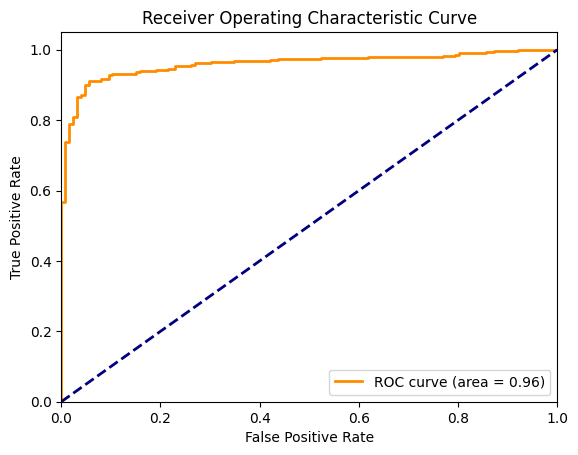

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 실제 라벨
y_true = merged_df['label'].values
y_preds = merged_df['generated'].values

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_true, y_preds)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

# ROC-AUC 면적 출력
print("ROC-AUC 면적:", roc_auc)

plt.show()

In [49]:
from sklearn.metrics import f1_score

# F1 스코어 계산
y_pred = [1 if score > 0.5 else 0 for score in y_preds]  # fixed_results는 모델 예측 결과로 가정
f1 = f1_score(y_true,  y_pred)

# F1 스코어 출력
print("F1 Score:", f1)

F1 Score: 0.9102244389027431
